In [1]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# adjust pandas display if you like
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 20)

# load (change filename/path if needed)
df = pd.read_csv('State_time_series.csv', low_memory=False)

# quick peek
df.shape, df.columns.tolist()


((13212, 82),
 ['Date',
  'RegionName',
  'DaysOnZillow_AllHomes',
  'InventorySeasonallyAdjusted_AllHomes',
  'InventoryRaw_AllHomes',
  'MedianListingPricePerSqft_1Bedroom',
  'MedianListingPricePerSqft_2Bedroom',
  'MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_AllHomes',
  'MedianListingPricePerSqft_CondoCoop',
  'MedianListingPricePerSqft_DuplexTriplex',
  'MedianListingPricePerSqft_SingleFamilyResidence',
  'MedianListingPrice_1Bedroom',
  'MedianListingPrice_2Bedroom',
  'MedianListingPrice_3Bedroom',
  'MedianListingPrice_4Bedroom',
  'MedianListingPrice_5BedroomOrMore',
  'MedianListingPrice_AllHomes',
  'MedianListingPrice_CondoCoop',
  'MedianListingPrice_DuplexTriplex',
  'MedianListingPrice_SingleFamilyResidence',
  'MedianPctOfPriceReduction_AllHomes',
  'MedianPctOfPriceReduction_CondoCoop',
  'MedianPctOfPriceReduction_SingleFamilyResidence',
  'MedianPriceCutDollar

In [2]:
# Cell 2
# Show overall info and check for the ZHVI_AllHomes column name
df.info()
print("\nSample columns containing ZHVI (search):")
[x for x in df.columns if 'ZHVI' in x or 'Zhvi' in x or 'zhvi' in x]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13212 entries, 0 to 13211
Data columns (total 82 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Date                                                           13212 non-null  object 
 1   RegionName                                                     13212 non-null  object 
 2   DaysOnZillow_AllHomes                                          4845 non-null   float64
 3   InventorySeasonallyAdjusted_AllHomes                           4896 non-null   float64
 4   InventoryRaw_AllHomes                                          4896 non-null   float64
 5   MedianListingPricePerSqft_1Bedroom                             3586 non-null   float64
 6   MedianListingPricePerSqft_2Bedroom                             4534 non-null   float64
 7   MedianListingPricePerSqft_3Bedroom                        

['ZHVIPerSqft_AllHomes',
 'ZHVI_1bedroom',
 'ZHVI_2bedroom',
 'ZHVI_3bedroom',
 'ZHVI_4bedroom',
 'ZHVI_5BedroomOrMore',
 'ZHVI_AllHomes',
 'ZHVI_BottomTier',
 'ZHVI_CondoCoop',
 'ZHVI_MiddleTier',
 'ZHVI_SingleFamilyResidence',
 'ZHVI_TopTier']

In [3]:
# Cell 3
# Convert Date column to datetime (coerce invalids to NaT)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# check for conversion problems
print("Date dtype:", df['Date'].dtype)
print("Missing dates:", df['Date'].isna().sum())

# Sort by RegionName and Date (important before interpolation)
df = df.sort_values(['RegionName', 'Date']).reset_index(drop=True)


Date dtype: datetime64[ns]
Missing dates: 0


In [4]:
# Cell 4
# replace the column name below if your file uses a different name
target_col = 'ZHVI_AllHomes'

# If the column isn't found, raise helpful message
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found. Available ZHVI-like columns: {[c for c in df.columns if 'ZHVI' in c or 'ZHV' in c]}")

df_multi = df[['Date', 'RegionName', target_col]].copy()
df_multi.rename(columns={target_col: 'ZHVI_AllHomes'}, inplace=True)  # normalized name
df_multi.head()


,Date,RegionName,ZHVI_AllHomes
0,1996-04-30,Alabama,79500.0
1,1996-05-31,Alabama,79200.0
2,1996-06-30,Alabama,79500.0
3,1996-07-31,Alabama,79700.0
4,1996-08-31,Alabama,79700.0


In [5]:
# Cell 5
coverage = df_multi.groupby('RegionName')['ZHVI_AllHomes'].apply(lambda s: s.notna().sum()).sort_values(ascending=False)
coverage.head(30)  # top 30 regions by non-null count

# percent missing overall
total_missing = df_multi['ZHVI_AllHomes'].isna().mean() * 100
print(f"\nOverall missing fraction for ZHVI_AllHomes: {total_missing:.2f}%")



Overall missing fraction for ZHVI_AllHomes: 5.86%


In [13]:
# Cell 6
# Interpolation function (works only on values, RegionName added outside)
def interpolate_region(g):
    g = g.sort_values("Date").copy()
    g['ZHVI_AllHomes'] = pd.to_numeric(g['ZHVI_AllHomes'], errors='coerce')
    g = g.set_index("Date")
    g['ZHVI_AllHomes'] = (
        g['ZHVI_AllHomes']
        .interpolate(method="time", limit_direction="both")
        .ffill()
        .bfill()
    )
    return g.reset_index()

# Keep RegionName when interpolating
df_interp = (
    df_multi[['Date', 'RegionName', 'ZHVI_AllHomes']]
    .groupby('RegionName', group_keys=False)[['Date', 'ZHVI_AllHomes']]
    .apply(interpolate_region)
    .reset_index(drop=True)
)

# Bring RegionName back from original df_multi
df_interp = df_interp.merge(
    df_multi[['Date', 'RegionName']],
    on='Date',
    how='left'
)

# Drop any rows still missing
df_interp = df_interp.dropna(subset=['ZHVI_AllHomes'])
print("Columns after interpolation:", df_interp.columns)
print("Missing after interpolation & cleanup:", df_interp['ZHVI_AllHomes'].isna().sum())


Columns after interpolation: Index(['Date', 'ZHVI_AllHomes', 'RegionName'], dtype='object')
Missing after interpolation & cleanup: 0


In [18]:
# Cell 7 — Outlier handling with RegionName kept

def rolling_median_outlier_replace(g, window=5, thresh=3):
    g = g.sort_values('Date').copy()
    s = pd.Series(g['ZHVI_AllHomes'].values, index=g['Date'])
    
    # Rolling median
    rolling_med = s.rolling(window=window, center=True, min_periods=1).median()
    
    # Rolling MAD (Median Absolute Deviation)
    rolling_mad = s.rolling(window=window, center=True, min_periods=1).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True
    )
    
    # Rolling std as fallback
    rolling_std = s.rolling(window=window, center=True, min_periods=1).std()
    
    # Deviation from median
    diff = (s - rolling_med).abs()
    
    # Mask: outlier if deviation > thresh * MAD (or std when MAD is invalid)
    mask_mad = diff > (thresh * rolling_mad)
    mask = mask_mad.fillna(False)
    missing_mad = rolling_mad.isna() | (rolling_mad == 0)
    mask_std = diff > (thresh * rolling_std)
    mask = mask | (mask_std & missing_mad)
    
    # Replace outliers with rolling median
    s_clean = s.where(~mask, rolling_med)
    g['ZHVI_AllHomes'] = s_clean.values
    return g

# ✅ Apply per region, keep RegionName by resetting index
df_clean = (
    df_interp[['Date', 'RegionName', 'ZHVI_AllHomes']]
    .groupby('RegionName', group_keys=True)
    .apply(rolling_median_outlier_replace, window=5, thresh=3)
    .reset_index(drop=True)
)

# Compare changes row by row
n_outliers_replaced = (df_interp['ZHVI_AllHomes'].values != df_clean['ZHVI_AllHomes'].values).sum()
print(f"Values replaced as outliers: {n_outliers_replaced}")

print("df_clean columns:", df_clean.columns)


Values replaced as outliers: 650812
df_clean columns: Index(['Date', 'RegionName', 'ZHVI_AllHomes'], dtype='object')


C:\Users\jvsti\AppData\Local\Temp\ipykernel_65200\3883511487.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rolling_median_outlier_replace, window=5, thresh=3)


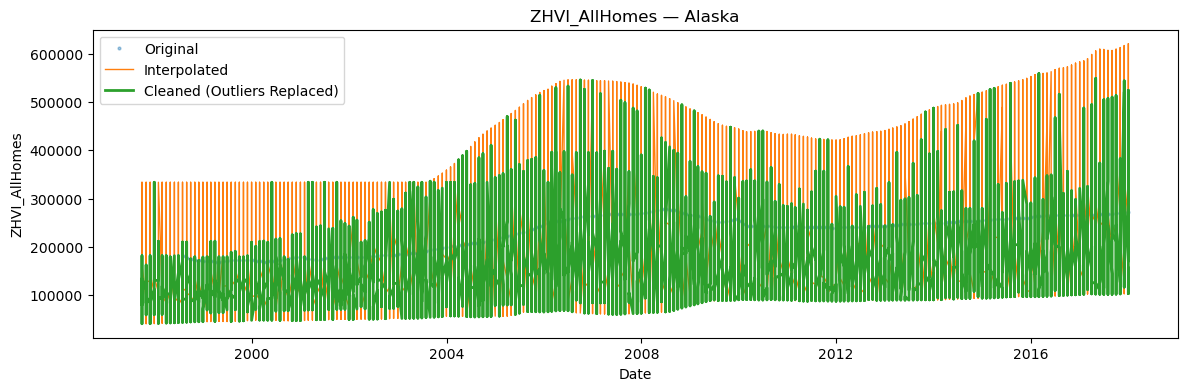

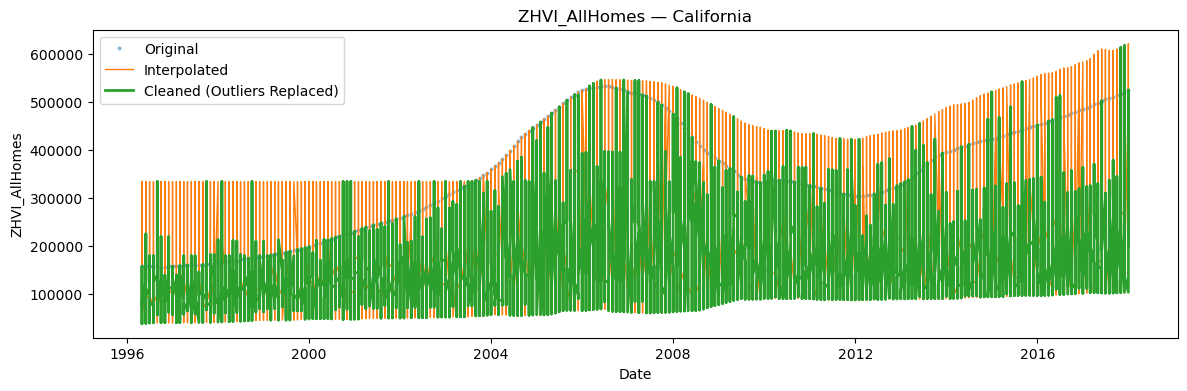

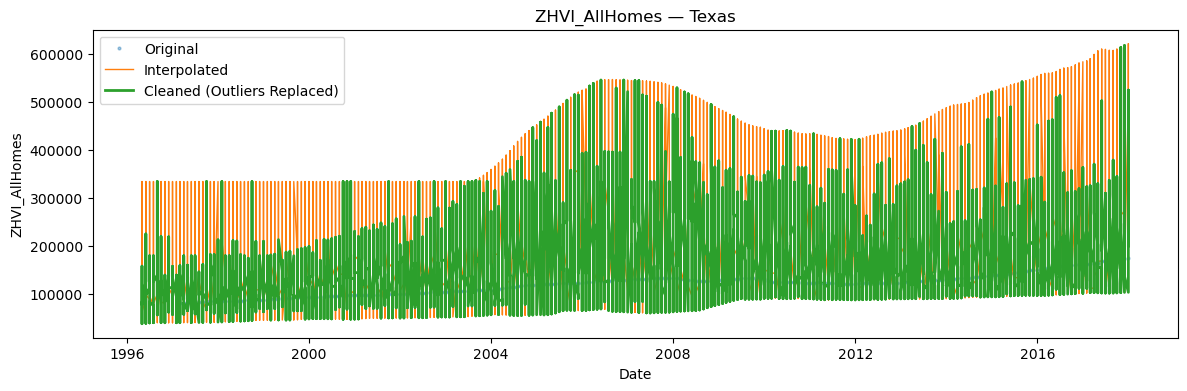

In [22]:
# Cell 8 — Plot comparison of Original, Interpolated, and Cleaned

def plot_region(region):
    # Match region ignoring case
    matches = [r for r in df_multi['RegionName'].unique() if region.lower() in r.lower()]
    if not matches:
        print(f"No matches found for '{region}'")
        return
    region_name = matches[0]  # take the first match
    
    orig = df_multi[df_multi['RegionName'] == region_name].sort_values('Date')
    interp = df_interp[df_interp['RegionName'] == region_name].sort_values('Date')
    clean = df_clean[df_clean['RegionName'] == region_name].sort_values('Date')

    plt.figure(figsize=(14,4))
    plt.plot(orig['Date'], orig['ZHVI_AllHomes'], label='Original', alpha=0.4, marker='.', linestyle='none', markersize=4)
    plt.plot(interp['Date'], interp['ZHVI_AllHomes'], label='Interpolated', linewidth=1)
    plt.plot(clean['Date'], clean['ZHVI_AllHomes'], label='Cleaned (Outliers Replaced)', linewidth=2)
    plt.title(f"ZHVI_AllHomes — {region_name}")
    plt.xlabel('Date')
    plt.ylabel('ZHVI_AllHomes')
    plt.legend()
    plt.show()

# Now you can just type part of the name
plot_region("Alaska")
plot_region("California")
plot_region("Texas")


In [21]:
# Check unique region names available
print(df_multi['RegionName'].unique()[:50])  # show first 50 regions


['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'DistrictofColumbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'NewHampshire'
 'NewJersey' 'NewMexico' 'NewYork' 'NorthCarolina' 'NorthDakota' 'Ohio'
 'Oklahoma' 'Oregon' 'Pennsylvania' 'RhodeIsland' 'SouthCarolina'
 'SouthDakota' 'Tennessee' 'Texas' 'UnitedStates' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'WestVirginia']


In [23]:
# Cell 9 — Validation & Save Cleaned Data

# ✅ Check final missing values
print("Missing values after full cleaning:", df_clean['ZHVI_AllHomes'].isna().sum())

# ✅ Check number of regions & records
print("Total regions:", df_clean['RegionName'].nunique())
print("Total rows:", len(df_clean))

# ✅ Save cleaned dataset to CSV
output_file = "State_time_series_ZHVI_cleaned.csv"
df_clean.to_csv(output_file, index=False)

print(f"Saved cleaned dataset as: {output_file}")


Missing values after full cleaning: 0
Total regions: 52
Total rows: 651336
Saved cleaned dataset as: State_time_series_ZHVI_cleaned.csv


In [25]:
# ✅ Train Prophet models for all 52 regions and save them using joblib

from prophet import Prophet
from joblib import dump
import pandas as pd

# Make sure your cleaned dataframe is ready
print(df_clean.columns)

# Get unique regions
regions = df_clean['RegionName'].unique()
print(f"Total regions detected: {len(regions)}")

# Container for all Prophet models
region_models = {}

# Loop through all regions
for region in regions:
    print(f"\n🚀 Training Prophet model for: {region}")
    
    # Prepare region-specific data
    region_df = (
        df_clean[df_clean['RegionName'] == region][['Date', 'ZHVI_AllHomes']]
        .rename(columns={'Date': 'ds', 'ZHVI_AllHomes': 'y'})
        .sort_values('ds')
    )

    # Initialize and fit Prophet model
    model = Prophet()
    model.fit(region_df)
    
    # Store model in dictionary
    region_models[region] = model

print("\n✅ All 52 Prophet models trained successfully!")

# Save all models into a single file
dump(region_models, "Prophet_AllRegions_Models.joblib")

print("\n💾 All models saved successfully to 'Prophet_AllRegions_Models.joblib'")


Index(['Date', 'RegionName', 'ZHVI_AllHomes'], dtype='object')
Total regions detected: 52

🚀 Training Prophet model for: Alabama


17:00:52 - cmdstanpy - INFO - Chain [1] start processing
17:00:53 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Alaska


17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:55 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Arizona


17:00:56 - cmdstanpy - INFO - Chain [1] start processing
17:00:57 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Arkansas


17:00:58 - cmdstanpy - INFO - Chain [1] start processing
17:01:00 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: California


17:01:00 - cmdstanpy - INFO - Chain [1] start processing
17:01:02 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Colorado


17:01:03 - cmdstanpy - INFO - Chain [1] start processing
17:01:04 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Connecticut


17:01:05 - cmdstanpy - INFO - Chain [1] start processing
17:01:06 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Delaware


17:01:07 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: DistrictofColumbia


17:01:09 - cmdstanpy - INFO - Chain [1] start processing
17:01:11 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Florida


17:01:12 - cmdstanpy - INFO - Chain [1] start processing
17:01:13 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Georgia


17:01:14 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Hawaii


17:01:16 - cmdstanpy - INFO - Chain [1] start processing
17:01:17 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Idaho


17:01:18 - cmdstanpy - INFO - Chain [1] start processing
17:01:20 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Illinois


17:01:20 - cmdstanpy - INFO - Chain [1] start processing
17:01:22 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Indiana


17:01:23 - cmdstanpy - INFO - Chain [1] start processing
17:01:24 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Iowa


17:01:25 - cmdstanpy - INFO - Chain [1] start processing
17:01:26 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Kansas


17:01:27 - cmdstanpy - INFO - Chain [1] start processing
17:01:28 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Kentucky


17:01:29 - cmdstanpy - INFO - Chain [1] start processing
17:01:31 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Louisiana


17:01:31 - cmdstanpy - INFO - Chain [1] start processing
17:01:33 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Maine


17:01:34 - cmdstanpy - INFO - Chain [1] start processing
17:01:35 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Maryland


17:01:36 - cmdstanpy - INFO - Chain [1] start processing
17:01:37 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Massachusetts


17:01:38 - cmdstanpy - INFO - Chain [1] start processing
17:01:39 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Michigan


17:01:40 - cmdstanpy - INFO - Chain [1] start processing
17:01:41 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Minnesota


17:01:42 - cmdstanpy - INFO - Chain [1] start processing
17:01:43 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Mississippi


17:01:44 - cmdstanpy - INFO - Chain [1] start processing
17:01:46 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Missouri


17:01:47 - cmdstanpy - INFO - Chain [1] start processing
17:01:48 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Montana


17:01:49 - cmdstanpy - INFO - Chain [1] start processing
17:01:50 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Nebraska


17:01:51 - cmdstanpy - INFO - Chain [1] start processing
17:01:52 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Nevada


17:01:53 - cmdstanpy - INFO - Chain [1] start processing
17:01:54 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: NewHampshire


17:01:55 - cmdstanpy - INFO - Chain [1] start processing
17:01:56 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: NewJersey


17:01:57 - cmdstanpy - INFO - Chain [1] start processing
17:01:58 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: NewMexico


17:01:59 - cmdstanpy - INFO - Chain [1] start processing
17:02:00 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: NewYork


17:02:01 - cmdstanpy - INFO - Chain [1] start processing
17:02:02 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: NorthCarolina


17:02:03 - cmdstanpy - INFO - Chain [1] start processing
17:02:05 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: NorthDakota


17:02:05 - cmdstanpy - INFO - Chain [1] start processing
17:02:06 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Ohio


17:02:07 - cmdstanpy - INFO - Chain [1] start processing
17:02:08 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Oklahoma


17:02:09 - cmdstanpy - INFO - Chain [1] start processing
17:02:10 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Oregon


17:02:11 - cmdstanpy - INFO - Chain [1] start processing
17:02:13 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Pennsylvania


17:02:13 - cmdstanpy - INFO - Chain [1] start processing
17:02:15 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: RhodeIsland


17:02:16 - cmdstanpy - INFO - Chain [1] start processing
17:02:17 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: SouthCarolina


17:02:18 - cmdstanpy - INFO - Chain [1] start processing
17:02:19 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: SouthDakota


17:02:20 - cmdstanpy - INFO - Chain [1] start processing
17:02:22 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Tennessee


17:02:23 - cmdstanpy - INFO - Chain [1] start processing
17:02:24 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Texas


17:02:25 - cmdstanpy - INFO - Chain [1] start processing
17:02:26 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: UnitedStates


17:02:27 - cmdstanpy - INFO - Chain [1] start processing
17:02:27 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Utah


17:02:28 - cmdstanpy - INFO - Chain [1] start processing
17:02:29 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Vermont


17:02:30 - cmdstanpy - INFO - Chain [1] start processing
17:02:32 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Virginia


17:02:33 - cmdstanpy - INFO - Chain [1] start processing
17:02:34 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Washington


17:02:35 - cmdstanpy - INFO - Chain [1] start processing
17:02:36 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: WestVirginia


17:02:37 - cmdstanpy - INFO - Chain [1] start processing
17:02:38 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Wisconsin


17:02:39 - cmdstanpy - INFO - Chain [1] start processing
17:02:40 - cmdstanpy - INFO - Chain [1] done processing



🚀 Training Prophet model for: Wyoming


17:02:41 - cmdstanpy - INFO - Chain [1] start processing
17:02:43 - cmdstanpy - INFO - Chain [1] done processing



✅ All 52 Prophet models trained successfully!

💾 All models saved successfully to 'Prophet_AllRegions_Models.joblib'


In [26]:
from joblib import load

# Load all Prophet models
region_models = load("Prophet_AllRegions_Models.joblib")

print(f"✅ Loaded {len(region_models)} Prophet models from file.")
print("Example keys:", list(region_models.keys())[:5])


✅ Loaded 52 Prophet models from file.
Example keys: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California']


In [27]:
import pandas as pd

region_forecasts = {}

for region, model in region_models.items():
    # Generate 12 months of future predictions
    future = model.make_future_dataframe(periods=12, freq='ME')
    forecast = model.predict(future)
    region_forecasts[region] = forecast

print(f"✅ Forecasts generated for {len(region_forecasts)} regions.")


✅ Forecasts generated for 52 regions.


In [28]:
all_forecasts = []
for region, forecast in region_forecasts.items():
    f = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    f['RegionName'] = region
    all_forecasts.append(f)

final_forecasts = pd.concat(all_forecasts)
final_forecasts.to_csv("Prophet_AllRegions_Forecasts.csv", index=False)

print("💾 Saved all forecasts to 'Prophet_AllRegions_Forecasts.csv'")


💾 Saved all forecasts to 'Prophet_AllRegions_Forecasts.csv'


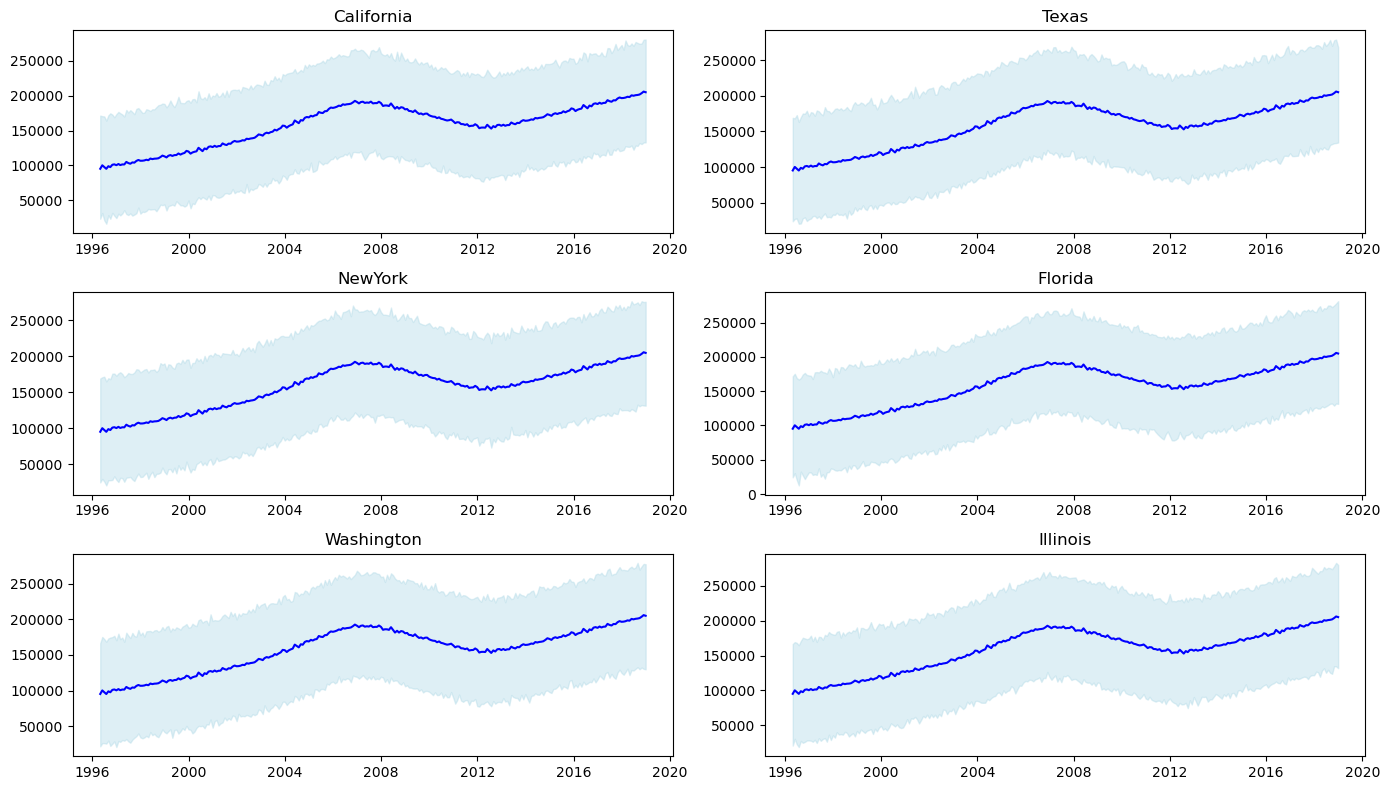

In [29]:
import matplotlib.pyplot as plt

sample_regions = ["California", "Texas", "NewYork", "Florida", "Washington", "Illinois"]

plt.figure(figsize=(14, 8))
for i, region in enumerate(sample_regions, 1):
    plt.subplot(3, 2, i)
    forecast = region_forecasts[region]
    plt.plot(forecast['ds'], forecast['yhat'], color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4)
    plt.title(region)
    plt.tight_layout()
plt.show()


In [30]:
# Cell — Evaluate Prophet models for all 52 regions

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from joblib import load

# Load previously saved models
region_models = load("Prophet_AllRegions_Models.joblib")
print(f"✅ Loaded {len(region_models)} models for evaluation")

# Create a results list
evaluation_results = []

# Loop through each region and evaluate
for region, model in region_models.items():
    # Prepare region’s actual data
    region_df = (
        df_clean[df_clean['RegionName'] == region][['Date', 'ZHVI_AllHomes']]
        .rename(columns={'Date': 'ds', 'ZHVI_AllHomes': 'y'})
        .sort_values('ds')
    )

    # Make predictions for the same historical dates
    forecast = model.predict(region_df[['ds']])
    
    # Align actual and predicted values
    y_true = region_df['y'].values
    y_pred = forecast['yhat'].values
    
    # Compute metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Store results
    evaluation_results.append({
        "RegionName": region,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(evaluation_results)

# Sort by lowest MAE (best performance)
metrics_df = metrics_df.sort_values(by="MAE").reset_index(drop=True)

# Display top and bottom performers
print("\n✅ Prophet Model Evaluation Completed!\n")
print("🔹 Top 5 Best Performing Regions:")
display(metrics_df.head(5))

print("\n🔸 Bottom 5 Least Accurate Regions:")
display(metrics_df.tail(5))


✅ Loaded 52 models for evaluation

✅ Prophet Model Evaluation Completed!

🔹 Top 5 Best Performing Regions:


,RegionName,MAE,RMSE,MAPE (%)
0,Alabama,42412.452415,56768.972946,28.665362
1,Arizona,42412.452415,56768.972946,28.665362
2,Arkansas,42412.452415,56768.972946,28.665362
3,California,42412.452415,56768.972946,28.665362
4,Connecticut,42412.452415,56768.972946,28.665362



🔸 Bottom 5 Least Accurate Regions:


,RegionName,MAE,RMSE,MAPE (%)
47,Montana,44295.563139,58355.288303,29.222224
48,Wyoming,44515.958421,58700.297368,29.341290
49,DistrictofColumbia,45296.419093,59961.659703,29.702538
50,UnitedStates,45541.342500,58111.041543,27.963957
51,NorthDakota,51237.830577,66344.658647,31.421569


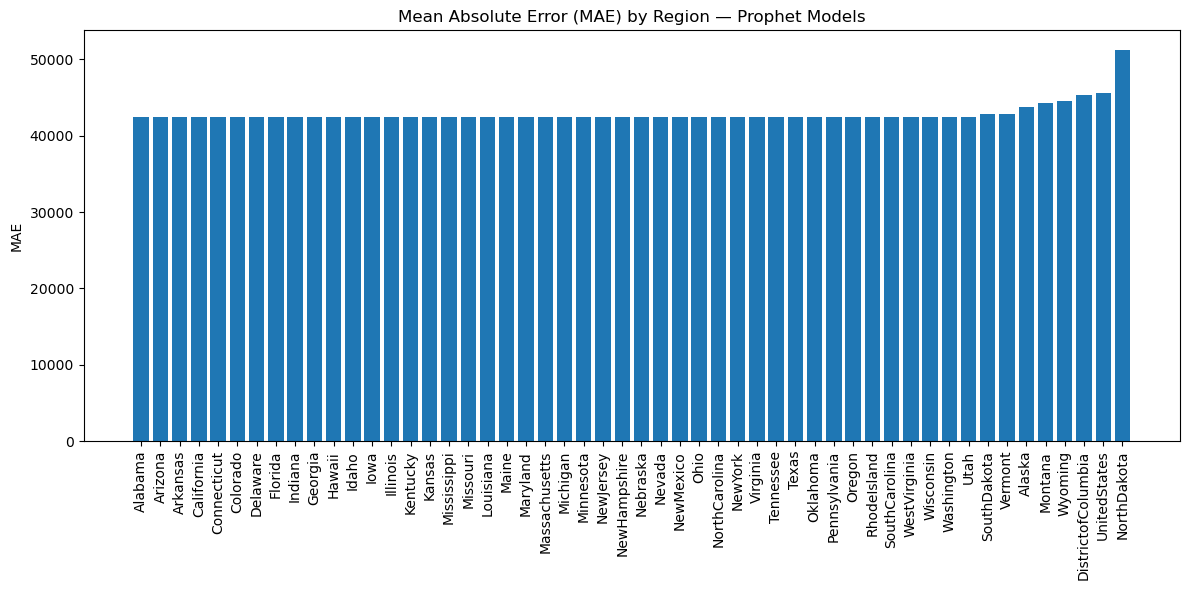

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(metrics_df['RegionName'], metrics_df['MAE'])
plt.xticks(rotation=90)
plt.title("Mean Absolute Error (MAE) by Region — Prophet Models")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


In [32]:
metrics_df.to_csv("Prophet_Model_Performance.csv", index=False)
print("💾 Saved Prophet model performance metrics to 'Prophet_Model_Performance.csv'")


💾 Saved Prophet model performance metrics to 'Prophet_Model_Performance.csv'


In [33]:
from joblib import load
import pandas as pd
from prophet import Prophet

# Load trained models
region_models = load("Prophet_AllRegions_Models.joblib")
print(f"✅ Loaded {len(region_models)} models for forecasting")

# Prepare a dictionary for forecasts
region_forecasts = {}

# Loop through each region and make predictions
for region, model in region_models.items():
    print(f"📈 Generating forecast for: {region}")

    # Create future dates (12 months ahead)
    future = model.make_future_dataframe(periods=12, freq='ME')

    # Predict using Prophet
    forecast = model.predict(future)

    # 🔧 Permanently rename columns right after prediction
    forecast.rename(columns={
        'ds': 'Date',
        'yhat': 'Predicted_Home_Price',
        'yhat_lower': 'Lower_Confidence_Interval',
        'yhat_upper': 'Upper_Confidence_Interval'
    }, inplace=True)

    # Keep only useful columns
    forecast = forecast[['Date', 'Predicted_Home_Price', 
                         'Lower_Confidence_Interval', 'Upper_Confidence_Interval']]

    # Store renamed forecast
    region_forecasts[region] = forecast

print("\n✅ Forecasts generated and renamed permanently for all 52 regions.")


✅ Loaded 52 models for forecasting
📈 Generating forecast for: Alabama
📈 Generating forecast for: Alaska
📈 Generating forecast for: Arizona
📈 Generating forecast for: Arkansas
📈 Generating forecast for: California
📈 Generating forecast for: Colorado
📈 Generating forecast for: Connecticut
📈 Generating forecast for: Delaware
📈 Generating forecast for: DistrictofColumbia
📈 Generating forecast for: Florida
📈 Generating forecast for: Georgia
📈 Generating forecast for: Hawaii
📈 Generating forecast for: Idaho
📈 Generating forecast for: Illinois
📈 Generating forecast for: Indiana
📈 Generating forecast for: Iowa
📈 Generating forecast for: Kansas
📈 Generating forecast for: Kentucky
📈 Generating forecast for: Louisiana
📈 Generating forecast for: Maine
📈 Generating forecast for: Maryland
📈 Generating forecast for: Massachusetts
📈 Generating forecast for: Michigan
📈 Generating forecast for: Minnesota
📈 Generating forecast for: Mississippi
📈 Generating forecast for: Missouri
📈 Generating forecast for

In [35]:
import pandas as pd

# Load the existing forecast file
file_path = "Prophet_AllRegions_Forecasts.csv"
df = pd.read_csv(file_path)

print("✅ Original columns:", list(df.columns))

# Rename Prophet’s default columns to meaningful names
df.rename(columns={
    'ds': 'Date',
    'yhat': 'Predicted_Home_Price',
    'yhat_lower': 'Lower_Confidence_Interval',
    'yhat_upper': 'Upper_Confidence_Interval'
}, inplace=True)

# Verify changes
print("✅ Renamed columns:", list(df.columns))

# Overwrite the same file (replaces old version)
df.to_csv("Prophet_AllRegions_Forecasts.csv", index=False)

print("💾 File updated successfully with new column names → 'Prophet_AllRegions_Forecasts.csv'")


✅ Original columns: ['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'RegionName']
✅ Renamed columns: ['Date', 'Predicted_Home_Price', 'Lower_Confidence_Interval', 'Upper_Confidence_Interval', 'RegionName']
💾 File updated successfully with new column names → 'Prophet_AllRegions_Forecasts.csv'
